In [ ]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math
from load_matlab_timedata import get_data_from
import sklearn.preprocessing 

In [55]:
! ls DC_motor_simulation

Copy_of_diff_eq_system.slx	     DC_motor_simulation.prj	  res.mat
Copy_of_diff_eq_system.slx.autosave  diff_eq_system.slx		  resources
Copy_of_diff_eq_system.slxc	     diff_eq_system.slx.original  slprj


In [56]:
data = get_data_from('DC_motor_simulation/res.mat')

<KeysViewHDF5 ['ans']>


In [57]:
num_datapoints = 1000

In [58]:
time, x, y = data[:num_datapoints, 0], data[:num_datapoints, 1], data[:num_datapoints, 2]

In [59]:
num_datapoints = time.shape[0]
num_datapoints

1000

In [60]:
try_sin = False
if try_sin:
    T = [ t for t in np.arange(0, math.pi * 10, math.pi / 100)]
    T = T[:num_datapoints]
    sin_t = [math.sin(t) for t in T]
    plt.plot(sin_t)
    x = np.array(T)
    y = np.array(sin_t)

In [61]:
x_normalized, x_norms = sklearn.preprocessing.normalize(x.reshape(-1,1),
                                                  axis = 0,
                                                  norm = 'max',
                                                  return_norm = True)
y_normalized, y_norms = sklearn.preprocessing.normalize(y.reshape(-1,1),
                                                  axis = 0,
                                                  norm = 'max', 
                                                  return_norm = True)

In [62]:
x = x_normalized
y = y_normalized

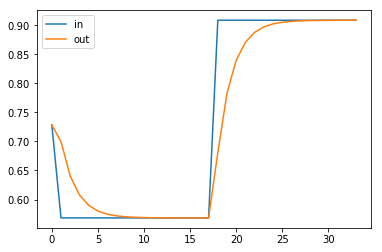

In [63]:
plt.plot(x[num_datapoints//6:num_datapoints//5], label = "in")
plt.plot(y[num_datapoints//6:num_datapoints//5], label = "out")
plt.legend()

Example of generating SIN wave of same len to werify model validity

In [64]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = num_datapoints
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

# Network params
input_size = 30
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 128
output_dim = 1
num_layers = 2
learning_rate = 1e-3
num_epochs = 5000
dtype = torch.float


In [65]:
x_batches = []
for i in range(input_size):
    x_batches.append(x[i:-(input_size-i)])
x = np.array(x_batches)
y = y[input_size:] # displacing

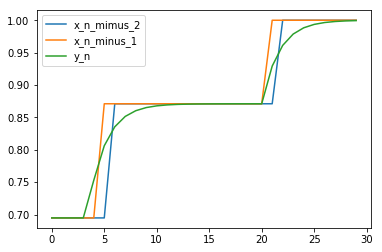

In [66]:
plt.plot(x[input_size-2][:30], label = 'x_n_mimus_2')
plt.plot(x[input_size-1][:30], label = 'x_n_minus_1')
plt.plot(y[:30], label='y_n')
plt.legend()

In [67]:
num_datapoints = x.shape[1]

In [68]:
x.shape

(30, 970, 1)

In [69]:
generate_data = False
#####################
# Generate data
#####################
if generate_data:
    from examples.generate_data import *
    data = ARData(num_datapoints,
                  num_prev=input_size,
                  test_size=test_size, 
                  noise_var=noise_var,
                  coeffs=fixed_ar_coefficients[input_size])

    # make training and test sets in torch
    X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
    X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
    y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
    y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

    X_train = X_train.view([input_size, -1, 1])
    X_test = X_test.view([input_size, -1, 1])
    plt.plot(data.X_train[:20, 12], label = '12')
    plt.plot(data.X_train[:20, 16], label = '16')
    plt.plot(data.X_train[:20, 19], label = '19')
    plt.plot(data.y_train[:20], label = 'out')

    plt.legend()

In [70]:
X_train = torch.from_numpy(x[:, :num_train]).type(torch.Tensor)
X_test = torch.from_numpy(x[:, num_train:]).type(torch.Tensor)
X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])
y_train = torch.from_numpy(y[:num_train, :]).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y[num_train:, :]).type(torch.Tensor).view(-1)

In [71]:
X_train.shape

torch.Size([30, 800, 1])

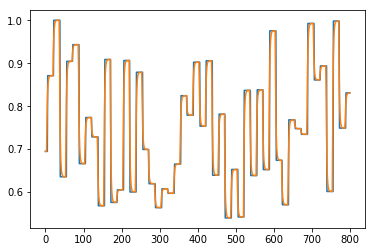

In [72]:
plt.plot(X_train.detach().numpy()[input_size-2])
plt.plot(y_train.detach().numpy())

In [73]:
def plot_multiscale(data, colors):
    fig, ax = plt.subplots()
    # Twin the x-axis twice to make independent y-axes.
    axes = [ax]
    if len(data) > 1:
        for i in range(len(data)-1):
            axes.append(ax.twinx())
    
    
    for ax, d, c in zip(axes, data, colors):
        ax.plot(d, color=c)
    plt.show()

In [74]:
X_train[0].shape

torch.Size([800, 1])

In [75]:
X_test[0].shape

torch.Size([170, 1])

In [76]:
y_train.shape

torch.Size([800])

In [77]:

#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size,
             h1,
             batch_size=num_train,
             output_dim=output_dim,
             num_layers=num_layers)



optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [78]:
loss_fn = torch.nn.MSELoss(size_average=False)

/home/dkushn/miniconda3/envs/dkushn_dyploma/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [79]:
print(output_dim)

1


Epoch  0 MSE:  371.5022888183594


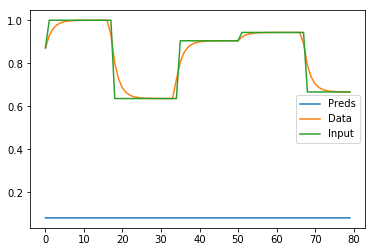

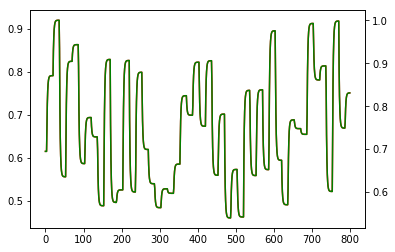

Epoch  100 MSE:  5.55556583404541


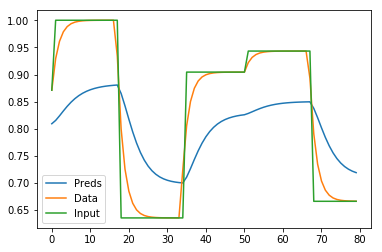

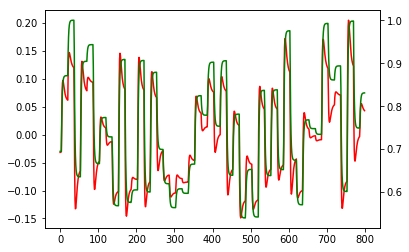

Epoch  200 MSE:  1.0895977020263672


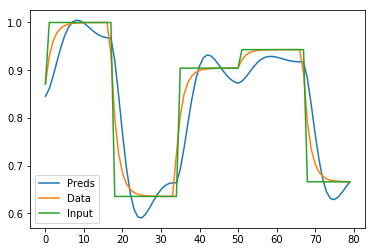

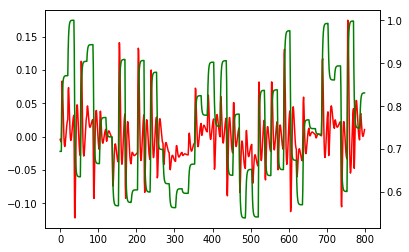

Epoch  300 MSE:  0.5724479556083679


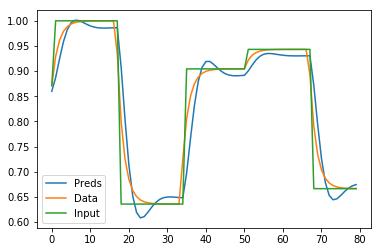

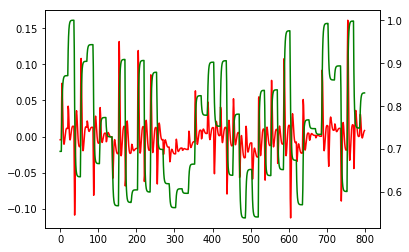

Epoch  400 MSE:  0.34910574555397034


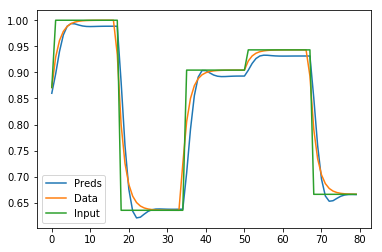

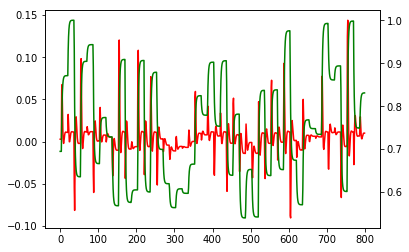

Epoch  500 MSE:  0.4719218611717224


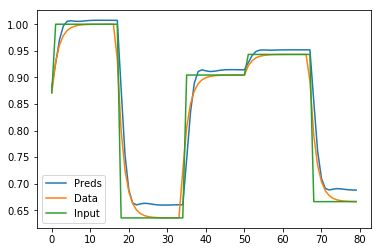

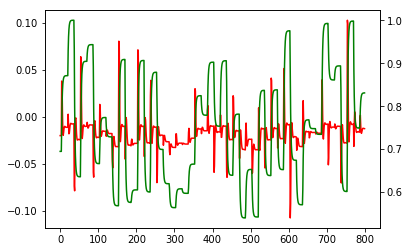

Epoch  600 MSE:  0.1773674041032791


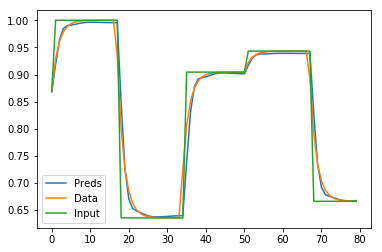

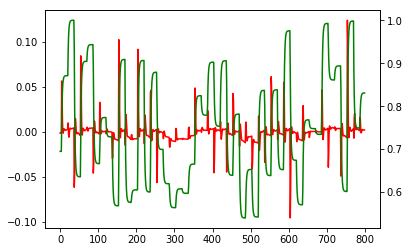

Epoch  700 MSE:  0.3757774531841278


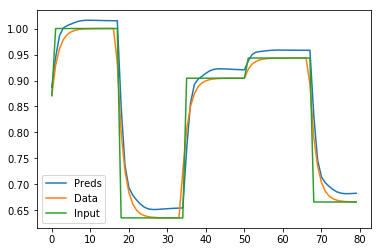

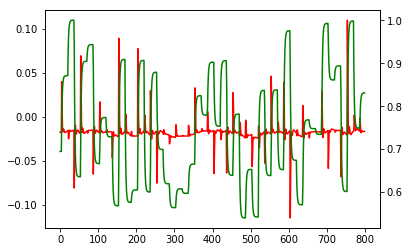

Epoch  800 MSE:  0.14270079135894775


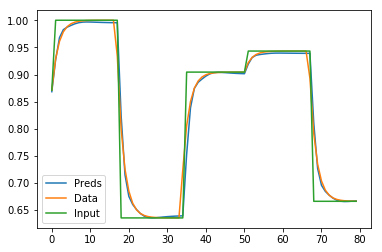

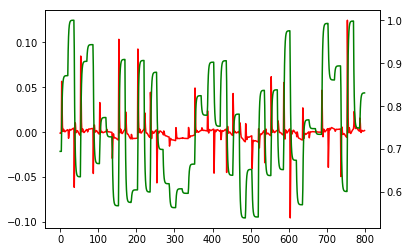

Epoch  900 MSE:  0.12823769450187683


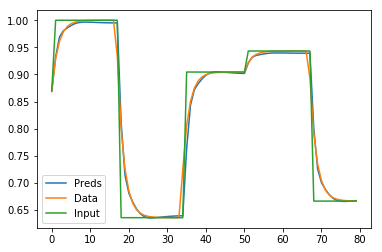

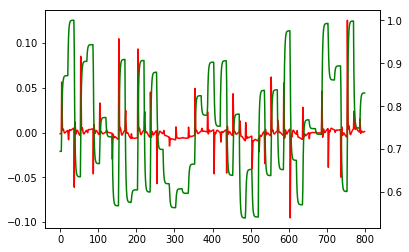

Epoch  1000 MSE:  0.12150024622678757


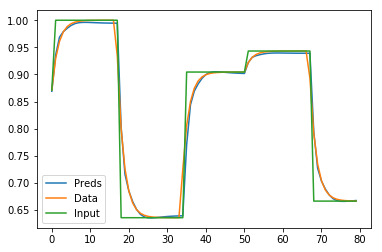

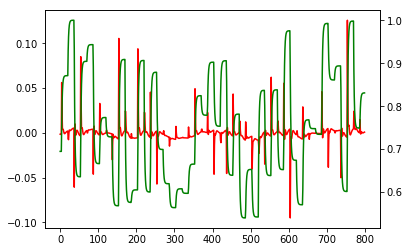

Epoch  1100 MSE:  0.11815048009157181


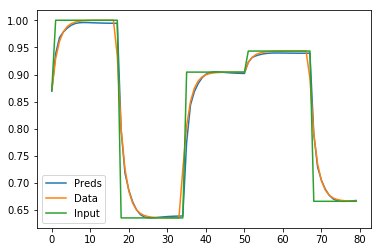

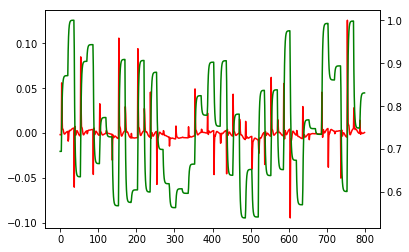

Epoch  1200 MSE:  0.12058236449956894


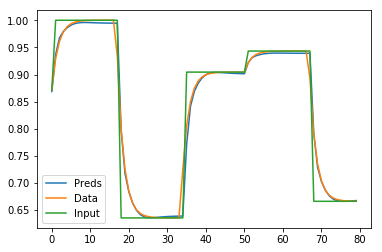

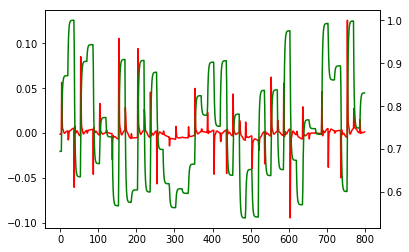

Epoch  1300 MSE:  0.1177123636007309


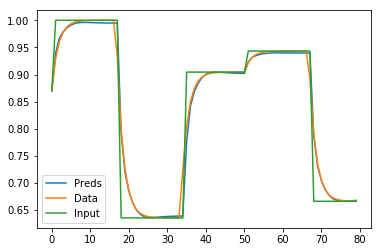

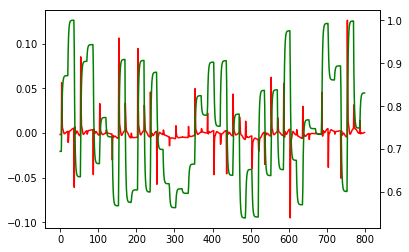

KeyboardInterrupt: 

In [81]:
#####################
# Train model
#####################



model.hidden = model.init_hidden()
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    hist = np.zeros(num_epochs)
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
        
        plt.plot(y_pred[20:100].detach().numpy(), label="Preds")
        plt.plot(y_train[20:100].detach().numpy(), label="Data")
        plt.plot(X_train[input_size-1][20:100].detach().numpy(), label="Input")
        plt.legend()
        plt.show()
        residuals = y_train-y_pred
        plot_multiscale(data=[residuals.detach().numpy(), y_train.detach().numpy()], 
               colors = ["Red", "Green"])
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


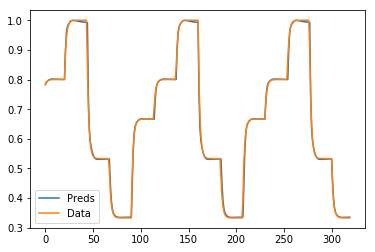

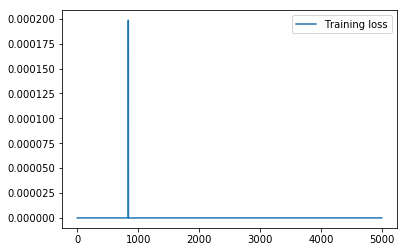

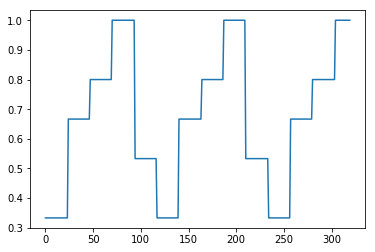

In [73]:

#####################
# Plot preds and performance
#####################
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
plt.plot(X_train[0, :, -1].detach().numpy(), label="ARG")